<b>1. อ่านไฟล์ข้อมูล</b>: ทำการเรียกแพคเกจที่จำเป็นต้องใช้ และแยกข้อมูลเป็น train, test

In [179]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
# อ่านไฟล์ข้อมูลให้เลือกใช้ filename ตามที่ตั้งชื่อไว้
file_name = './Data/housing.csv'
df = pd.read_csv(file_name)

<b>2. แบ่งข้อมูลเป็น Test/Train Set </b>: ใช้อัตราส่วน 8:2

In [ ]:
# แบ่งข้อมูลเป็น test, train
(df_train,df_test) =train_test_split(df.copy(), test_size=0.2)

<b>3. ทำการ EDA เบื้องต้น:</b> นำตัวแปร latitude, longitude มาสร้าง scatter plot เพื่อดูความสัมพันธ์กับราคาบ้าน แต่เรามีข้อมูลเป็นจะนวนหลายจุด การแสดงผลอาจจะทำให้เห็นภาพไม่ชัด เราจะทำการสุ่มตัวอย่างมาแค่ 1000 ตัวอย่าง จะเห็นได้ว่าตัวแปร latitude, longitude ไม่ได้มีวามสัมพันธ์กับมูลค่าที่ชัดเจน

C:\Users\weerapat.sa\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\weerapat.sa\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


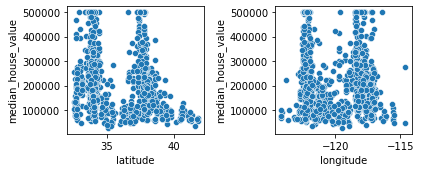

In [181]:
fig, axes = plt.subplots(1,2,figsize=(6,2.5))
#สุ่มตัวอย่าง 
sample = df_train.sample(1000)
sns.scatterplot('latitude','median_house_value',data=sample,ax=axes[0])
sns.scatterplot('longitude','median_house_value',data=sample,ax=axes[1])
fig.tight_layout()

นำพิกัดจุดมา plot ระบายสีตามราคาบ้าน จะพบว่าบ้านที่อยู่ใกล้เส้นสีเขียวจะมีราคาแพงกว่า

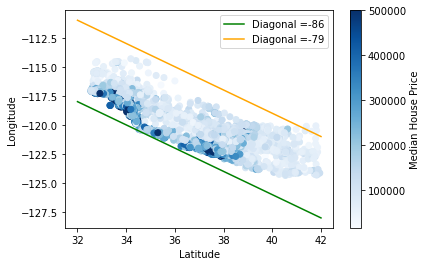

In [61]:
plt.scatter(df_train['latitude'],df_train['longitude'],c = df_train['median_house_value'],cmap= 'Blues')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
cb = plt.colorbar()
cb.set_label("Median House Price")
x = np.linspace(32, 42, 1000)
plt.plot(x,-86-x,label = 'Diagonal =-86',color='green')
plt.plot(x,-79-x,label = 'Diagonal =-79',color='orange')
plt.legend()

กำหนดตัวแปร
$$ diagonal = latitude + longitude$$
จากนั้นสร้าง scatter plot ระหว่าง diagonal และราคาบ้าน จะมีความสัมพันธ์ค่อนข้างชัดเจน

<AxesSubplot:xlabel='diagonal', ylabel='median_house_value'>

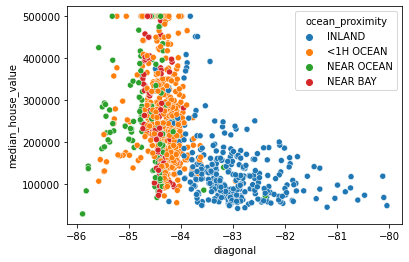

In [182]:
df_train['diagonal'] =df_train['latitude']+df_train['longitude']
df_test['diagonal'] =df_test['latitude']+df_test['longitude']
sns.scatterplot(x='diagonal',y='median_house_value',data=df_train.sample(1000),hue='ocean_proximity')

<b>4. ทำ Principal Component Analysis: </b> เริ่มจากการสร้างตัวแปรใหม่

In [183]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
# เลือกตัวแปรพิกัด
train_location = df_train[['latitude','longitude']]
test_location = df_test[['latitude','longitude']]
pca_fit =pca.fit(train_location)
# สร้างตัวแปรใหม่
df_train[['PCA_1','PCA_2']]= pca_fit.transform(train_location)
df_test[['PCA_1','PCA_2']]= pca_fit.transform(test_location)

สร้าง Scatter Plot ระบายสีตามแต่ละ component

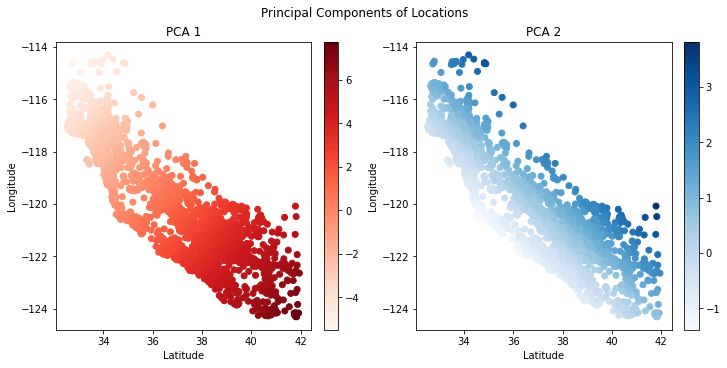

In [187]:
fig, (ax1,ax2) = plt.subplots(1,2,constrained_layout= True,figsize=(10,5))
fig.suptitle('Principal Components of Locations')
ax1.title.set_text('PCA 1')
plot1 = ax1.scatter(df_train['latitude'],df_train['longitude'],c = df_train['PCA_1'],cmap= 'Reds')
ax1.set_xlabel('Latitude')
ax1.set_ylabel('Longitude')
plt.colorbar(plot1,ax=ax1)
ax2.title.set_text('PCA 2')
plot2 = ax2.scatter(df_train['latitude'],df_train['longitude'],c = df_train['PCA_2'],cmap= 'Blues')
ax2.set_xlabel('Latitude')
ax2.set_ylabel('Longitude')
plt.colorbar(plot2,ax=ax2)

<b>5. การหาระยะห่างจากเมืองใหญ่ </b>

In [191]:
# สร้าง dictionary เพื่อระบุชื่อและพิกัดเมืองใหญ่
location_dict = {'San Francisco':(37.77,-122.41),'Los Angeles':(34.25,-118.24)}

# สร้างคอลัมน์หาระยะทางจากเมืองที่ใกล่ที่สุด และชื่อเมืองที่ใกล้ที่สุด
def find_closest_cities(df):
    for city in location_dict:
        lat = location_dict[city][0]
        lon = location_dict[city][1]
        dist = np.sqrt(np.square(df['latitude']-lat)
                                    +np.square(df['longitude']-lon))
        try:
            df['closest_city'] = np.where(df['dis_city']>dist,city,df['closest_city'])
            df['dis_city']= np.where(df['dis_city']>dist,dist,df['dis_city'])
        except:
            df['dis_city'] = dist
            df['closest_city'] = city
    return (df['dis_city'],df['closest_city'])

# ใส่ feature ที่สร้างึ้นมาไปใน Dataframe
df_train['dis_city'] ,df_train['closest_city'] = find_closest_cities(df_train)
df_test['dis_city'] ,df_test['closest_city'] = find_closest_cities(df_test)

ทำการ Sample ตัวอย่างมา 2000 ตัวอย่างเพื่อมาสร้างแผนภาพเส้นทางจากเมืองใหญ่ถึงบ้านใน Census

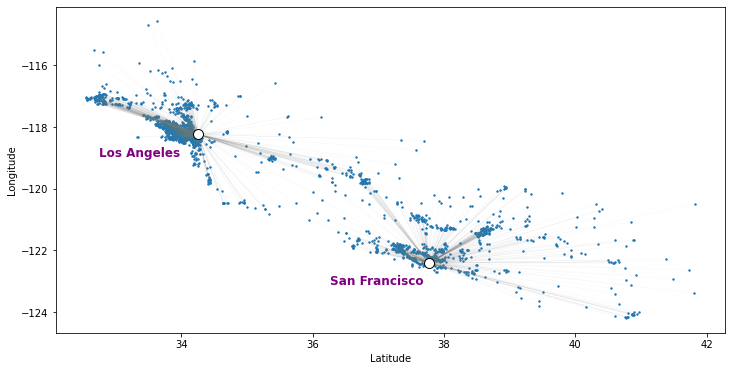

In [189]:
df_sample = df_train.sample(2000).reset_index()
plt.figure(figsize=(12,6))
for i in range(2000):
    x1 = location_dict[df_sample.loc[i,'closest_city']][0]
    y1 = location_dict[df_sample.loc[i,'closest_city']][1]
    x2 = df_sample.loc[i,'latitude']
    y2 = df_sample.loc[i,'longitude']
    plt.plot([x1,x2],[y1,y2],c='grey',linewidth=0.1,alpha=0.3)
plt.scatter('latitude','longitude',data=df_sample,s=2)
plt.xlabel('Latitude')
plt.ylabel('Longitude')
for city in location_dict:
    plt.plot(location_dict[city][0],location_dict[city][1],marker='o',
             markeredgecolor='black',markerfacecolor='white',markersize=10)
    plt.text(location_dict[city][0]-1.5,location_dict[city][1]-0.7,city,color='purple',fontsize=12,fontweight= 'heavy')

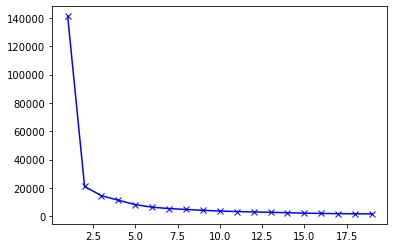

In [149]:
from sklearn.cluster import KMeans
distortions = []
K=range(1,15)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(train_location)
    distortions.append(kmeanModel.inertia_)
plt.plot(K, distortions, 'bx-')


C:\Users\weerapat.sa\AppData\Local\Temp/ipykernel_7832/2781887260.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_location['clusters'] = KMeans(n_clusters=10).fit(train_location).predict(train_location)


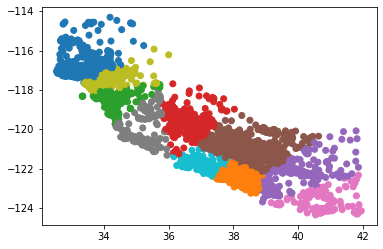

In [159]:
train_location['clusters'] = KMeans(n_clusters=10).fit(train_location).predict(train_location)
plt.scatter('latitude','longitude',data=train_location,c='clusters',cmap='tab10')

In [161]:
df_train.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity', 'diagonal', 'PCA_1', 'PCA_2',
       'dis_city', 'closest_city'],
      dtype='object')

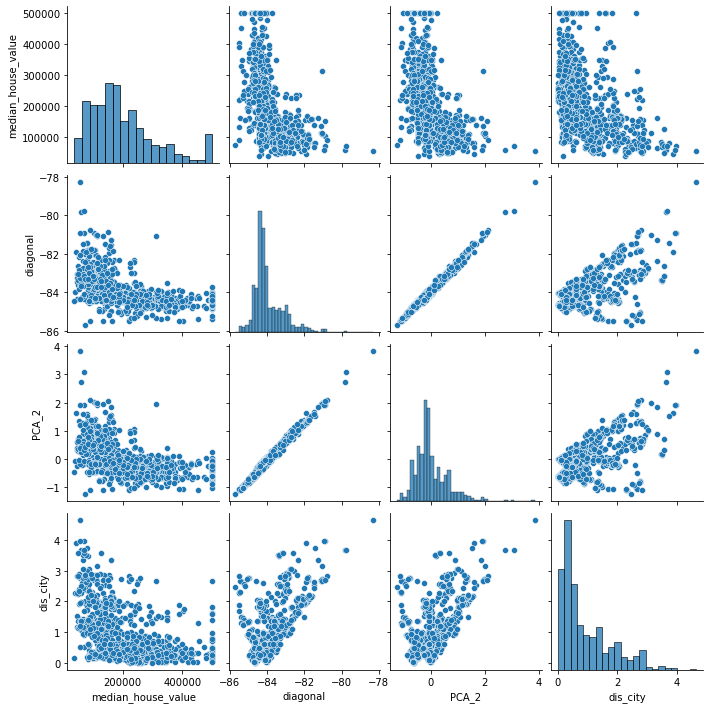

In [174]:
selected_columns = df_train[['median_house_value', 'diagonal',  'PCA_2',
       'dis_city']].sample(1000)
sns.pairplot(selected_columns)